In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

# 버스, 지하철

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
bus_path = '../data/bus_feature.csv'
subway_path  = '../data/subway_feature.csv'
dt_bus = pd.read_csv(bus_path)
dt_subway = pd.read_csv(subway_path)

In [3]:
dt_bus.shape, dt_subway.shape

((12584, 6), (768, 5))

# Test, Train 데이터 확인

In [4]:
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [5]:
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])

In [6]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

# 데이터 수정

- x,y 좌표 결측치 체우기

In [7]:
xy_path  = '../data/xy.csv'
dt_xy = pd.read_csv(xy_path, encoding='cp949')

In [8]:
# 시군구와 번지를 기준으로 concat과 dt_xy를 병합
merged_df = pd.merge(concat, dt_xy[['시군구', '번지', 'x', 'y']], how='left', on=['시군구', '번지'])

# 좌표X와 좌표Y가 결측치인 경우에만 dt_xy에서 가져온 x, y 값으로 채우기
concat['좌표X'].fillna(merged_df['x'], inplace=True)
concat['좌표Y'].fillna(merged_df['y'], inplace=True)

In [9]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

## 필요없다고 생각되는 열 삭제 및 자료에 맞춰서 다시 구성

- k열 삭제

In [10]:
# 첫 글자가 'k'로 시작하는 열 삭제
cols_to_drop = [col for col in concat.columns if col.startswith('k')]
concat.drop(columns=cols_to_drop, inplace=True)

In [11]:
# 남길 열들의 리스트
columns_to_keep = ['시군구', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']

# 해당 열들만 남기고 나머지 열 삭제
concat = concat[columns_to_keep]

In [12]:
concat.head(5)

,시군구,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,주차대수,좌표X,좌표Y,target,is_test
0,서울특별시 강남구 개포동,개포6차우성,79.97,201712,8,3,1987,언주로 3,262.0,127.05721,37.476763,124000.0,0
1,서울특별시 강남구 개포동,개포6차우성,79.97,201712,22,4,1987,언주로 3,262.0,127.05721,37.476763,123500.0,0
2,서울특별시 강남구 개포동,개포6차우성,54.98,201712,28,5,1987,언주로 3,262.0,127.05721,37.476763,91500.0,0
3,서울특별시 강남구 개포동,개포6차우성,79.97,201801,3,4,1987,언주로 3,262.0,127.05721,37.476763,130000.0,0
4,서울특별시 강남구 개포동,개포6차우성,79.97,201801,8,2,1987,언주로 3,262.0,127.05721,37.476763,117000.0,0


In [13]:
# 1. '시군구'에서 '서울특별시'를 제거하고 '구'와 '동'으로 나누기
concat['구'] = concat['시군구'].str.split(' ').str[1]  # '구' 부분 추출
concat['동'] = concat['시군구'].str.split(' ').str[2]  # '동' 부분 추출

# 2. '계약년월'에서 연도 추출 후 건축년도와의 차이를 계산하여 '구매당시 아파트 나이' 열 추가
concat['계약연도'] = concat['계약년월'].astype(str).str[:4].astype(int)  # 계약년월에서 연도만 추출
concat['구매당시 아파트 나이'] = concat['계약연도'] - concat['건축년도']  # 건축년도와의 차이 계산

concat.drop(columns=['시군구', '계약년월', '계약일', '건축년도'], inplace=True)

# 결과 확인
concat.head(10)

,아파트명,전용면적,층,도로명,주차대수,좌표X,좌표Y,target,is_test,구,동,계약연도,구매당시 아파트 나이
0,개포6차우성,79.97,3,언주로 3,262.0,127.05721,37.476763,124000.0,0,강남구,개포동,2017,30
1,개포6차우성,79.97,4,언주로 3,262.0,127.05721,37.476763,123500.0,0,강남구,개포동,2017,30
2,개포6차우성,54.98,5,언주로 3,262.0,127.05721,37.476763,91500.0,0,강남구,개포동,2017,30
3,개포6차우성,79.97,4,언주로 3,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
4,개포6차우성,79.97,2,언주로 3,262.0,127.05721,37.476763,117000.0,0,강남구,개포동,2018,31
5,개포6차우성,79.97,1,언주로 3,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
6,개포6차우성,79.97,2,언주로 3,262.0,127.05721,37.476763,139500.0,0,강남구,개포동,2018,31
7,개포6차우성,54.98,5,언주로 3,262.0,127.05721,37.476763,107500.0,0,강남구,개포동,2018,31
8,개포6차우성,79.97,3,언주로 3,262.0,127.05721,37.476763,145000.0,0,강남구,개포동,2018,31
9,개포6차우성,54.98,3,언주로 3,262.0,127.05721,37.476763,112000.0,0,강남구,개포동,2018,31


In [14]:
# 열 순서 변경
new_order = ['구', '동', '계약연도', '구매당시 아파트 나이'] + [col for col in concat.columns if col not in ['구', '동', '계약연도', '구매당시 아파트 나이']]
concat = concat[new_order]

# 결과 확인
concat.tail()

,구,동,계약연도,구매당시 아파트 나이,아파트명,전용면적,층,도로명,주차대수,좌표X,좌표Y,target,is_test
9267,중랑구,신내동,2023,9,신내우디안1단지,84.65,13,신내역로1길 85,1568.0,127.10672,37.61887,NaN,1
9268,중랑구,신내동,2023,9,신내우디안1단지,84.62,12,신내역로1길 85,1568.0,127.10672,37.61887,NaN,1
9269,중랑구,신내동,2023,9,신내우디안1단지,101.65,12,신내역로1길 85,1568.0,127.10672,37.61887,NaN,1
9270,중랑구,신내동,2023,9,신내우디안1단지,84.94,18,신내역로1길 85,1568.0,127.10672,37.61887,NaN,1
9271,중랑구,신내동,2023,9,신내우디안1단지,84.65,13,신내역로1길 85,1568.0,127.10672,37.61887,NaN,1


## 버스, 지하철 데이터와 x,y좌표 이용하기

In [15]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj
from tqdm import tqdm

def preprocess_data(df, x_col, y_col):
    wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 좌표계 (위도, 경도)
    utm_k = pyproj.CRS('EPSG:5179')  # UTM-K 좌표계 (한국)
    project = pyproj.Transformer.from_crs(wgs84, utm_k, always_xy=True).transform
    
    df['geometry'] = df.apply(lambda row: Point(project(row[x_col], row[y_col])), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs=utm_k)

def calculate_density(gdf_real_estate, gdf_locations, radius):
    gdf_real_estate['buffer'] = gdf_real_estate.geometry.buffer(radius)
    
    joined = sjoin(gdf_locations, gdf_real_estate.set_geometry('buffer'), how='inner', predicate='within')
    
    density = joined.groupby(joined.index_right).size().rename('density')
    
    return gdf_real_estate.join(density, how='left').fillna(0)['density']

def process_in_chunks(df, locations_gdf, radius, chunk_size=10000):
    results = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size]
        chunk_gdf = preprocess_data(chunk, '좌표X', '좌표Y')
        density = calculate_density(chunk_gdf, locations_gdf, radius)
        results.append(density)
    return pd.concat(results)

# 버스 정류장과 지하철역 데이터 전처리
bus_gdf = preprocess_data(dt_bus, 'X좌표', 'Y좌표')  # 버스 정류장 좌표계 변환

# 지하철 데이터는 위도, 경도 데이터를 X, Y로 변환
subway_gdf = preprocess_data(dt_subway, '경도', '위도')  # 지하철 데이터도 동일하게 좌표 변환

# 반경 설정
bus_radius = 500  # 미터 단위
subway_radius = 1000  # 1km를 미터 단위로 표현

# 청크 크기 설정
chunk_size = 10000

print("버스 정류장 밀도 계산 중 (500m 반경)...")
concat['bus_stop_density_500m'] = process_in_chunks(concat, bus_gdf, bus_radius, chunk_size)

print("지하철역 밀도 계산 중 (1km 반경)...")
concat['subway_station_density_1km'] = process_in_chunks(concat, subway_gdf, subway_radius, chunk_size)

# 결과 출력
print(concat[['좌표X', '좌표Y', 'bus_stop_density_500m', 'subway_station_density_1km']].head())

버스 정류장 밀도 계산 중 (500m 반경)...


100%|██████████| 113/113 [00:42<00:00,  2.63it/s]


지하철역 밀도 계산 중 (1km 반경)...


100%|██████████| 113/113 [00:35<00:00,  3.23it/s]

         좌표X        좌표Y  bus_stop_density_500m  subway_station_density_1km
0  127.05721  37.476763                   13.0                         0.0
1  127.05721  37.476763                   13.0                         0.0
2  127.05721  37.476763                   13.0                         0.0
3  127.05721  37.476763                   13.0                         0.0
4  127.05721  37.476763                   13.0                         0.0


In [16]:
concat.isnull().sum()

구                                  0
동                                  0
계약연도                               0
구매당시 아파트 나이                        0
아파트명                            2136
전용면적                               0
층                                  0
도로명                                0
주차대수                          876277
좌표X                            18548
좌표Y                            18548
target                          9272
is_test                            0
bus_stop_density_500m              0
subway_station_density_1km         0
dtype: int64

In [17]:
concat.shape

(1128094, 15)

In [18]:
concat = concat.drop(columns=['좌표X', '좌표Y'])

In [19]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   구                           1128094 non-null  object 
 1   동                           1128094 non-null  object 
 2   계약연도                        1128094 non-null  int64  
 3   구매당시 아파트 나이                 1128094 non-null  int64  
 4   아파트명                        1125958 non-null  object 
 5   전용면적                        1128094 non-null  float64
 6   층                           1128094 non-null  int64  
 7   도로명                         1128094 non-null  object 
 8   주차대수                        251817 non-null   float64
 9   target                      1118822 non-null  float64
 10  is_test                     1128094 non-null  int64  
 11  bus_stop_density_500m       1128094 non-null  float64
 12  subway_station_density_1km  1128094 non-null  float64
dtype

In [20]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['계약연도', '구매당시 아파트 나이', '전용면적', '층', '주차대수', 'target', 'is_test', 'bus_stop_density_500m', 'subway_station_density_1km']
범주형 변수: ['구', '동', '아파트명', '도로명']


In [21]:
# 범주형 변수에 대한 보간
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [22]:
concat.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

구                             0
동                             0
계약연도                          0
구매당시 아파트 나이                   0
아파트명                          0
전용면적                          0
층                             0
도로명                           0
주차대수                          0
target                        0
is_test                       0
bus_stop_density_500m         0
subway_station_density_1km    0
dtype: int64

## 강남 여부

In [23]:
all = list(concat['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [24]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat['강남여부'] = is_gangnam

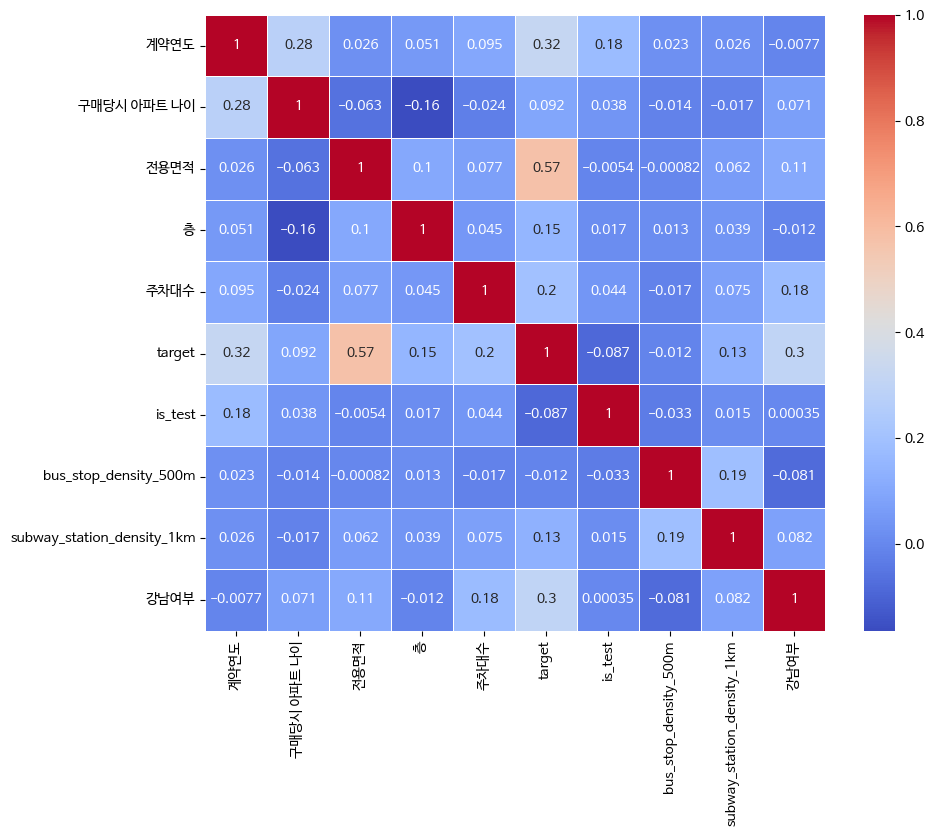

In [25]:
# 상관계수 행렬 계산
corr_matrix = concat.corr()

# 상관계수 행렬 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# 결과 출력
plt.show()

# 학습

In [26]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 13) (9272, 13)


In [27]:
dt_test.head(5)

,구,동,계약연도,구매당시 아파트 나이,아파트명,전용면적,층,도로명,주차대수,target,bus_stop_density_500m,subway_station_density_1km,강남여부
0,강남구,개포동,2023,36,개포6차우성,79.9700,5,언주로 3,262.0,13250.0,13.0,0.0,1
1,강남구,개포동,2023,2,개포더샵트리에,108.2017,10,개포로 311,305.0,13250.0,15.0,5.0,1
2,강남구,개포동,2023,39,개포우성3차,161.0000,15,개포로 307,419.0,13250.0,19.0,4.0,1
3,강남구,개포동,2023,39,개포우성3차,133.4600,14,개포로 307,419.0,13250.0,19.0,4.0,1
4,강남구,개포동,2023,39,개포우성3차,104.4300,6,개포로 307,419.0,13250.0,19.0,4.0,1


In [28]:
dt_test['target'] = 0

In [29]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['계약연도', '구매당시 아파트 나이', '전용면적', '층', '주차대수', 'target', 'bus_stop_density_500m', 'subway_station_density_1km', '강남여부']
범주형 변수: ['구', '동', '아파트명', '도로명']


In [30]:
categorical_columns_v2.remove('구')
categorical_columns_v2

['동', '아파트명', '도로명']

In [31]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

 33%|███▎      | 1/3 [00:00<00:00,  3.56it/s]

100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


In [32]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,구,동,계약연도,구매당시 아파트 나이,아파트명,전용면적,층,도로명,주차대수,target,bus_stop_density_500m,subway_station_density_1km,강남여부
0,강남구,8,2017,30,328,79.97,3,6176,262.0,124000.0,13.0,0.0,1


In [33]:
# one-hot 인코딩
categorical_columns_1 = ['구']
dt_train = pd.get_dummies(dt_train, columns=categorical_columns_1, drop_first=True)
dt_train

,동,계약연도,구매당시 아파트 나이,아파트명,전용면적,층,도로명,주차대수,target,bus_stop_density_500m,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,8,2017,30,328,79.97,3,6176,262.0,124000.0,13.0,...,0,0,0,0,0,0,0,0,0,0
1,8,2017,30,328,79.97,4,6176,262.0,123500.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8,2017,30,328,54.98,5,6176,262.0,91500.0,13.0,...,0,0,0,0,0,0,0,0,0,0
3,8,2018,31,328,79.97,4,6176,262.0,130000.0,13.0,...,0,0,0,0,0,0,0,0,0,0
4,8,2018,31,328,79.97,2,6176,262.0,117000.0,13.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,21,2007,9,215,59.94,11,4816,366.0,20000.0,20.0,...,0,0,0,0,0,0,1,0,0,0
1118818,21,2007,9,215,59.94,10,4816,366.0,20000.0,20.0,...,0,0,0,0,0,0,1,0,0,0
1118819,21,2007,9,215,84.83,20,4816,366.0,28000.0,20.0,...,0,0,0,0,0,0,1,0,0,0
1118820,21,2007,9,215,84.83,8,4816,366.0,29000.0,20.0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
categorical_columns_1 = ['구']
dt_test = pd.get_dummies(dt_test, columns=categorical_columns_1, drop_first=True)
dt_test

,동,계약연도,구매당시 아파트 나이,아파트명,전용면적,층,도로명,주차대수,target,bus_stop_density_500m,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,8,2023,36,328,79.9700,5,6176,262.0,0,13.0,...,0,0,0,0,0,0,0,0,0,0
1,8,2023,2,329,108.2017,10,469,305.0,0,15.0,...,0,0,0,0,0,0,0,0,0,0
2,8,2023,39,333,161.0000,15,467,419.0,0,19.0,...,0,0,0,0,0,0,0,0,0,0
3,8,2023,39,333,133.4600,14,467,419.0,0,19.0,...,0,0,0,0,0,0,0,0,0,0
4,8,2023,39,333,104.4300,6,467,419.0,0,19.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,174,2023,9,3670,84.6500,13,5555,1568.0,0,12.0,...,0,0,0,0,0,0,0,0,0,1
9268,174,2023,9,3670,84.6200,12,5555,1568.0,0,12.0,...,0,0,0,0,0,0,0,0,0,1
9269,174,2023,9,3670,101.6500,12,5555,1568.0,0,12.0,...,0,0,0,0,0,0,0,0,0,1
9270,174,2023,9,3670,84.9400,18,5555,1568.0,0,12.0,...,0,0,0,0,0,0,0,0,0,1


# 모델 학습

In [35]:
# 같음
assert dt_train.shape[1] == dt_test.shape[1]

In [36]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [37]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [38]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 8432.15101327254


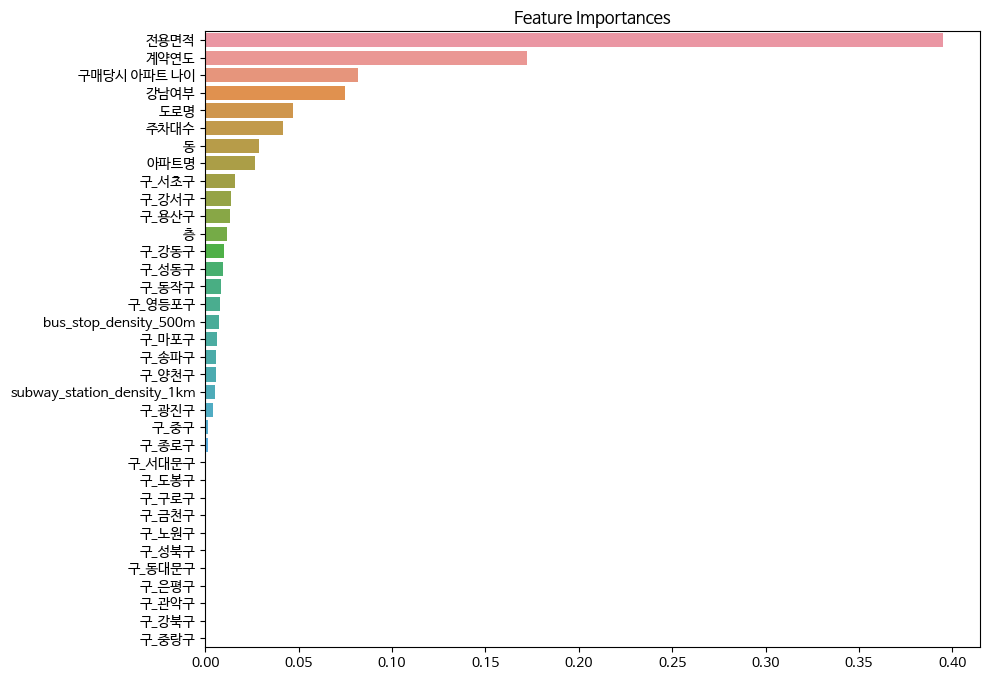

In [39]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [40]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [41]:
dt_test.head(2)

,동,계약연도,구매당시 아파트 나이,아파트명,전용면적,층,도로명,주차대수,target,bus_stop_density_500m,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,8,2023,36,328,79.9700,5,6176,262.0,0,13.0,...,0,0,0,0,0,0,0,0,0,0
1,8,2023,2,329,108.2017,10,469,305.0,0,15.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [43]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 20 ms, sys: 3.97 ms, total: 24 ms
Wall time: 17.1 ms


In [44]:
real_test_pred

array([222000., 240600., 317300., ...,  75200.,  68400.,  79240.])

In [45]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)